# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [29]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


## Data Preparation

In [30]:
# Beispiel Daten laden
data = pd.read_csv('./../Data/preprocessed_df_v2.csv') # Pfad zu Ihren Daten

print(data.head())

# Auffüllen von NaN-Werten mit dem Mittelwert der jeweiligen Spalte
data = data.fillna(data.mean())

# Überprüfen auf NaN-Werte in den Daten
assert not np.any(np.isnan(data)), "Daten enthalten NaN-Werte"


   participant_id  test_id  test_duration  mental  physical  temporal  \
0               1        1      33.643950      10         5        15   
1               1        2      28.484322      50        30        25   
2               1        3      71.423823     100        10        75   
3               1        4      38.163442      60        15        45   
4               2        1      41.748047      20        10        20   

   performance  effort  frustration  mean  ...  blinkrate  fixationrate  \
0           25      25           10  15.0  ...   0.059446      0.295946   
1           50      15           25  32.5  ...   0.000000      0.175533   
2           80      90           20  62.5  ...   0.196013      0.196018   
3           50      20           25  35.8  ...   0.052406      0.288263   
4           10      20           15  15.8  ...   0.000000      0.143727   

   blinkrate_rel  blinkrate_rel_pct  fixationrate_rel  fixationrate_rel_pct  \
0       0.000000           0.00

In [31]:
# Daten skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# GAN-Parameter
latent_dim = 100
data_dim = data_scaled.shape[1]

## GAN Definition

In [32]:
# Generator-Modell
def build_generator(latent_dim, data_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(data_dim, activation='tanh'))
    return model

# Diskriminator-Modell
def build_discriminator(data_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN-Modell
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [39]:
# Modelle erstellen

learning_rate_discriminator = 0.00005
learning_rate_generator = 0.0001

generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.compile(optimizer=Adam(learning_rate_discriminator, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(learning_rate_generator, 0.5), loss='binary_crossentropy')

# Trainingsdaten
real = data_scaled
real_labels = np.ones((real.shape[0], 1))
fake_labels = np.zeros((real.shape[0], 1))

## Training

In [40]:
# GAN-Training
epochs = 1000
batch_size = 32

d_losses = []
g_losses = []

for epoch in range(epochs):
    # Zufällige Samples von realen Daten
    idx = np.random.randint(0, real.shape[0], batch_size)
    real_samples = real[idx]
    
    # Zufälliges Rauschen und Fake-Daten generieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise)
    
    # Diskriminator trainieren
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels[:batch_size])
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels[:batch_size])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # GAN trainieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels[:batch_size])
    
    # Verluste speichern
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    
    # Fortschritt ausgeben
    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

print("Training abgeschlossen!")
print(f"{epochs} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

1/1 [==============================] - 0s 92ms/step
0 [D loss: 0.7010182738304138, acc.: 48.4375%] [G loss: 0.748386025428772]
1/1 [==============================] - 0s 16ms/step
Training abgeschlossen!
1000 [D loss: 0.465548038482666, acc.: 85.9375%] [G loss: 1.3286285400390625]


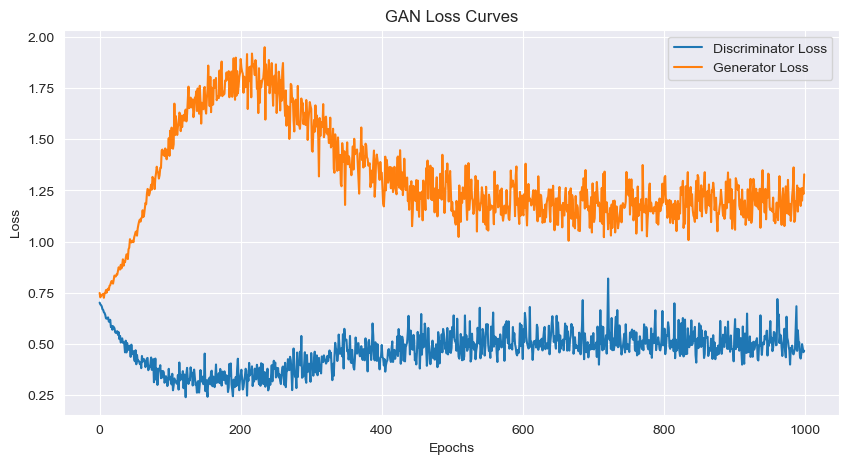

In [41]:
# Verlustkurven plotten
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curves")
plt.show()

## Daten generieren

In [36]:
# Generieren von zusätzlichen Datenpunkten nach dem Training
num_additional_points = 1000
noise = np.random.normal(0, 1, (num_additional_points, latent_dim))
synthetic_data_scaled = generator.predict(noise)

# Die generierten Daten zurückskalieren auf den ursprünglichen Wertebereich
synthetic_data = scaler.inverse_transform(synthetic_data_scaled)

# Die generierten Daten mit den Originaldaten kombinieren
augmented_data = np.vstack((data, synthetic_data))

# Optional: Konvertieren Sie die Daten in ein TensorFlow-Dataset
dataset = tf.data.Dataset.from_tensor_slices(augmented_data)

print("Original Data Shape:", data.shape)
print("Synthetic Data Shape:", synthetic_data.shape)
print("Augmented Data Shape:", augmented_data.shape)

32/32 [==============================] - 0s 872us/step
Original Data Shape: (188, 22)
Synthetic Data Shape: (1000, 22)
Augmented Data Shape: (1188, 22)


In [38]:
# Ausgewählte Datenpunkte plotten
synthetic_data = pd.DataFrame(synthetic_data, columns=data.columns)
print("Synthetic Data")
print(synthetic_data[:5])

Synthetic Data
   participant_id   test_id  test_duration     mental   physical   temporal  \
0       15.136143  1.876261      32.621937  65.242119  20.171387  14.481913   
1       14.733645  3.967613      39.788216  96.005074  42.578842  41.330257   
2       37.536678  3.997689     121.412811  96.887665  27.431963  90.334152   
3       18.916821  2.284517      54.168228  80.583557  32.839638  17.666334   
4       30.360859  3.074938      79.667831  76.263733  39.462368  47.219337   

   performance     effort  frustration       mean  ...  blinkrate  \
0    20.756216  82.367447    13.616369  25.494108  ...   0.027346   
1    42.339462  93.329674    25.957005  53.132675  ...   0.459833   
2    71.449944  88.521812    62.087231  62.402096  ...   0.866985   
3    26.739618  66.556183     7.519396  14.061541  ...   0.023329   
4     6.692411  85.045677    74.552734  61.357178  ...   0.144687   

   fixationrate  blinkrate_rel  blinkrate_rel_pct  fixationrate_rel  \
0      0.148504      -0.